This notebook simulates causal mutations and their effect sizes using custom functions from the grg_pheno_sim library, generating 500 random effect sizes drawn from a normal distribution. These effect sizes are combined with genotype data to calculate additive genetic values for each individual (representing the sum of effects across all causal variants they carry), which are then aggregated from the sample-level (400 samples representing diploid individuals) to the individual-level (200 individuals). Finally, the genetic values are normalized to have a mean of zero and variance of one.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import pygrgl

from grg_pheno_sim.effect_size import sim_grg_causal_mutation, additive_effect_sizes, samples_to_individuals, normalize_genetic_values
from grg_pheno_sim.model import grg_causal_mutation_model

from test_phenotype_sim.effect_size_test import test_additive_effect_sizes


The following command only serves the purpose of converting the VCF zip file into a GRG that will be used for the phenotype simulation. The bash script below will function as expected given the relative path for the source data file is accurate.

In [2]:
%%script bash --out /dev/null
if [ ! -f test-200-samples.grg ]; then
  grg construct -p 10 ../data/test-200-samples.vcf.gz --out-file test-200-samples.grg
fi

In [3]:
grg_1 = pygrgl.load_immutable_grg("test-200-samples.grg") #loading in a sample grg stored in the same directory


In [4]:
num = grg_1.num_samples
print("The number of sample nodes in this grg is " + str(num))
num_nodes = grg_1.num_nodes
print("The number of nodes in this grg is " + str(num_nodes))
num_mutations = grg_1.num_mutations
print("The number of mutations in this grg is " + str(num_mutations))

The number of sample nodes in this grg is 400
The number of nodes in this grg is 8759
The number of mutations in this grg is 10893


In [5]:
rng = np.random.default_rng()

mean_1 = 0.0  
var_1 = 1.0  
model_normal = grg_causal_mutation_model("normal", mean=mean_1, var=var_1)

#simulating effect sizes using just the model
num_causal = 1000  #number of causal sites

effect_sizes = model_normal.sim_effect_size(num_causal, rng)

print("Simulated Effect Sizes:", effect_sizes)

Simulated Effect Sizes: [ 6.64626768e-01 -8.97556067e-01 -8.20995415e-01 -1.37748144e+00
  8.13270799e-01  4.75861905e-01 -7.34786377e-01  1.06942613e+00
  7.26701299e-01 -1.12070099e+00 -1.20033856e-01 -1.77214251e+00
  2.42430439e-01 -9.83260659e-01  4.89448989e-02 -1.49532007e+00
  4.33918184e-03 -1.20087389e+00  1.66347284e+00  1.36632502e+00
  1.12400469e+00  7.67609292e-01 -1.26065040e+00 -9.93879126e-02
  9.67434815e-01  9.69112957e-01  1.52599397e+00 -1.12151294e+00
 -1.03075634e+00  1.44255388e+00  8.14980205e-01  1.54990631e+00
  5.96108206e-01  1.44008017e+00  3.20159236e-02 -2.52817859e-01
  3.74696854e-01 -6.10167563e-01  3.00342610e-01 -7.95898107e-02
 -2.16479692e-01  8.69305889e-02  2.38220185e-02  3.12336913e-01
  7.83160163e-02 -2.45889702e+00  9.97565994e-01  5.06059123e-01
  1.75364960e+00 -1.10238622e+00 -2.66988375e-01 -1.75874428e+00
 -1.63048719e+00  8.79619267e-01  1.47454771e+00  1.03648633e+00
  1.42818105e+00  1.97890244e+00  2.87640661e-01  4.09666807e-01
 

In [6]:

trait_df_normal = sim_grg_causal_mutation(grg_1, num_causal=num_causal, model=model_normal, random_seed=1)

trait_df_normal #this is the pandas data frame showing the results using the normal distribution

,mutation_id,effect_size,causal_mutation_id
0,20,-1.810258,0
1,28,1.151768,0
2,62,1.681257,0
3,76,2.346698,0
4,119,-0.286668,0
...,...,...,...
995,10862,-0.221163,0
996,10874,-1.136983,0
997,10879,-0.966133,0
998,10883,-1.402602,0


In [7]:
sample_nodes_df = additive_effect_sizes(grg_1, trait_df_normal)


In [8]:
sample_nodes_df #the pandas dataframe containing only the sample nodes and their associated genetic values, 400 sample nodes expected

,sample_node_id,genetic_value,causal_mutation_id
0,0,-4.863310,0
1,1,-11.638354,0
2,2,-6.301743,0
3,3,3.847395,0
4,4,-4.820758,0
...,...,...,...
395,395,-8.190154,0
396,396,3.420223,0
397,397,-4.084002,0
398,398,-11.381398,0


In [9]:
ground_truth_genetic_value = test_additive_effect_sizes(grg_1, trait_df_normal) #this uses a recursive hard-coded method that finds each sample nodes ancestors to ensure correct effect sizes are passed down
ground_truth_genetic_value

[-4.863310045461939,
 -11.638353566173759,
 -6.301743429441365,
 3.847395388980957,
 -4.82075773305127,
 -12.483045444740892,
 3.958297339029589,
 2.682916184105841,
 -6.5932999967406545,
 -2.116912510097515,
 -1.6808547626443053,
 10.418203388920563,
 9.449719805698841,
 2.3137596385582766,
 -13.853389959405337,
 14.572103932065774,
 12.984315205145661,
 -0.6723184513872942,
 -5.151429668773794,
 -9.439626348536,
 -18.574689884716467,
 -15.845338982323417,
 -18.364074864860275,
 7.711830018714413,
 -5.941979038876323,
 -17.939965021519406,
 -10.902878166416185,
 -22.712456132951722,
 -16.684332147013322,
 -5.7669189334205315,
 -11.671443632330211,
 1.5489526108845264,
 -12.380086442701748,
 -3.075769967997594,
 4.547112064945489,
 -2.3970323990131943,
 0.595193462699698,
 -15.173269245697373,
 -10.573836491617044,
 -10.846244169641237,
 1.4521090925884184,
 -7.122069927511784,
 -15.516570776021728,
 -5.210787592608397,
 -15.076238711799112,
 -3.946418372938047,
 -14.33738125266332,
 -

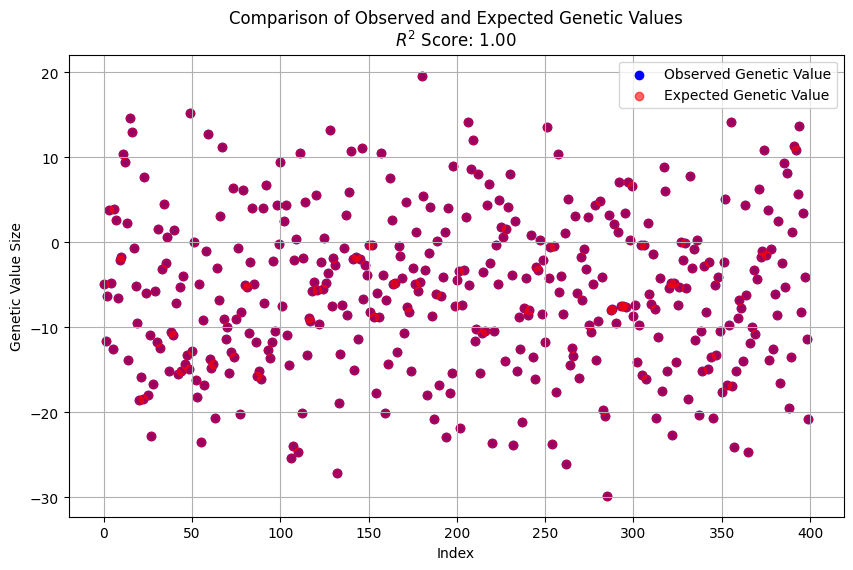

In [10]:
r2 = r2_score(ground_truth_genetic_value, sample_nodes_df['genetic_value']) #plotting the expected versus actual genetic values to verify the additive function

plt.figure(figsize=(10, 6))
plt.scatter(range(len(sample_nodes_df['genetic_value'])), sample_nodes_df['genetic_value'], color='blue', label='Observed Genetic Value')
plt.scatter(range(len(ground_truth_genetic_value)), ground_truth_genetic_value, color='red', alpha=0.6, label='Expected Genetic Value')

plt.title(f'Comparison of Observed and Expected Genetic Values\n$R^2$ Score: {r2:.2f}')
plt.xlabel('Index')
plt.ylabel('Genetic Value Size')
plt.legend()

plt.grid(True)

plt.show()

In [11]:
individual_genetic_value_df = samples_to_individuals(sample_nodes_df) #this combines the sample nodes into individual nodes

individual_genetic_value_df #half the number of individuals as compared to samples, due to diploid case

,individual_id,genetic_value,causal_mutation_id
0,0,-16.501664,0
1,1,-2.454348,0
2,2,-17.303803,0
3,3,6.641214,0
4,4,-8.710213,0
...,...,...,...
195,195,12.536488,0
196,196,16.549154,0
197,197,5.463626,0
198,198,-0.663779,0


In [12]:
normalized_genetic_value_df = normalize_genetic_values(individual_genetic_value_df) #sets mean to 0 and variance to 1 by default
normalized_genetic_value_df

,individual_id,genetic_value,causal_mutation_id
0,0,-0.375568,0
1,1,0.686386,0
2,2,-0.436209,0
3,3,1.373995,0
4,4,0.213453,0
...,...,...,...
195,195,1.819668,0
196,196,2.123019,0
197,197,1.284972,0
198,198,0.821750,0


In [13]:
new_mean = normalized_genetic_value_df['genetic_value'].mean()
new_std = normalized_genetic_value_df['genetic_value'].std()
new_var = normalized_genetic_value_df['genetic_value'].var()

print("The new mean of the genetic values is " + str(new_mean))
print("The new standard deviation of the genetic values is " + str(new_std))
print("The new variance of the genetic values is " + str(new_var))

The new mean of the genetic values is -1.1990408665951691e-16
The new standard deviation of the genetic values is 0.9999999999999998
The new variance of the genetic values is 0.9999999999999997
